In [ ]:
import torch
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from pylab import rcParams

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

try:
  import cleanlab
except:
  !pip install cleanlab
  import cleanlab
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 12.8 MB/s 


In [ ]:
try:
  import timm
except:
  !pip install timm
  import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 15.8 MB/s 
     |████████████████████████████████| 182 kB 71.5 MB/s 


In [ ]:
# Continue with regular imports
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3303, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 3303 (delta 141), reused 233 (delta 112), pack-reused 3020
Receiving objects: 100% (3303/3303), 642.58 MiB | 21.52 MiB/s, done.
Resolving deltas: 100% (1871/1871), done.
Checking out files: 100% (221/221), done.


# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/NNDL/Released_Data/train/'
test_path = '/content/drive/MyDrive/NNDL/Released_Data/test/'

In [ ]:
#put on gpu if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
'''uncomment this section if we move forward with more customized training.'''
# train_transforms = train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomGrayscale(0.5),
#     transforms.RandomAdjustSharpness(2, 0.5), # adjust sharpness by a factor of 2 with prob 0.5 of it being adjusted
#     transforms.RandomInvert(p=0.5),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.TrivialAugmentWide(num_magnitude_bins=31), # change intensity of image with max being 31 
#     transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])

'uncomment this section if we move forward with more customized training.'

In [ ]:
'''process below follows:
https://www.learnpytorch.io/06_pytorch_transfer_learning/'''

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                               test_dir=test_path,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0020a4de80>,
 ['bird', 'dog', 'reptile'])

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


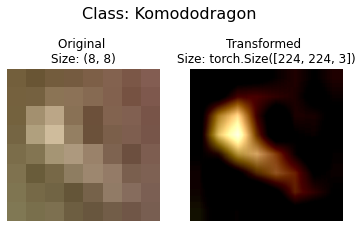

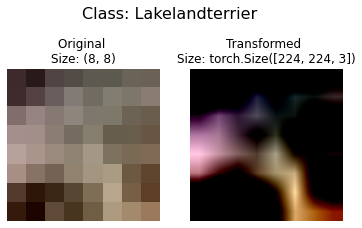

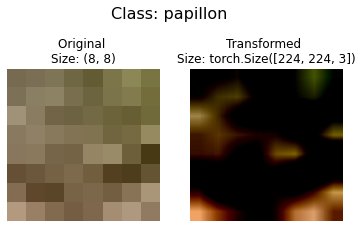

In [ ]:
#this returns a posix path to every image in our training directory 
image_paths = list(Path(train_path).glob("*/*/*.jpg"))

plot_transformed_images(image_paths, 
                        transform=manual_transforms, 
                        n=3)

In [ ]:
weights2 = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1 # .DEFAULT = best available weights from pretraining on ImageNet
weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
#create data loaders using the auto transforms from the trained model 
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                               test_dir=test_path,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff0a9a060d0>,
 ['bird', 'dog', 'reptile'])

In [ ]:
import torch
import torchvision
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

In [ ]:
model2 = torchvision.models.convnext_base(weights=weights2).to(device) #change weight if using this model

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

In [ ]:
#convnext.classifier[2] = nn.Linear(1024, output_shape, bias=True).to(device)

In [ ]:
#model = nn.Sequential(nn.Upsample(scale_factor=4), convnext)

In [ ]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" ISSUE WITH 8X8 INPUTS
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24, 112

In [ ]:
# Freeze all base layers in the "features" section of the model
#layers = [model.conv_proj.parameters(), model.encoder.parameters()]
#for layer in layers:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

model.classifier[1] = nn.Linear(1280, output_shape)

# Recreate the classifier layer and seed it to the target device
#model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
 #   torch.nn.Linear(in_features=1024, 
  #                  out_features=output_shape, # same number of output units as our number of classes
   #                 bias=True)).to(device)

In [ ]:
#look at summary again after adjusting our sequential layer 
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

In [ ]:

print(output_shape)

3


In [ ]:
#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=25,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1109 | train_acc: 0.3456 | test_loss: 1.0884 | test_acc: 0.3884
Epoch: 2 | train_loss: 1.1066 | train_acc: 0.3593 | test_loss: 1.0809 | test_acc: 0.3964
Epoch: 3 | train_loss: 1.1006 | train_acc: 0.3719 | test_loss: 1.0786 | test_acc: 0.3944
Epoch: 4 | train_loss: 1.0986 | train_acc: 0.3759 | test_loss: 1.0698 | test_acc: 0.4270
Epoch: 5 | train_loss: 1.0947 | train_acc: 0.3853 | test_loss: 1.0784 | test_acc: 0.3981
Epoch: 6 | train_loss: 1.1007 | train_acc: 0.3756 | test_loss: 1.0666 | test_acc: 0.4284
Epoch: 7 | train_loss: 1.0951 | train_acc: 0.3907 | test_loss: 1.0590 | test_acc: 0.4409
Epoch: 8 | train_loss: 1.0945 | train_acc: 0.3922 | test_loss: 1.0573 | test_acc: 0.4464
Epoch: 9 | train_loss: 1.0933 | train_acc: 0.3865 | test_loss: 1.0562 | test_acc: 0.4463
Epoch: 10 | train_loss: 1.0982 | train_acc: 0.3842 | test_loss: 1.0535 | test_acc: 0.4544
Epoch: 11 | train_loss: 1.0944 | train_acc: 0.3825 | test_loss: 1.0573 | test_acc: 0.4466
Epoch: 12 | train_l

In [ ]:
print(model.parameters)

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(model = model,
           target_dir ='/content/drive/MyDrive/NN and DL/projects/Released_Data/',
           model_name = 'efficientnet_v2_s_gce_1.pth')      

[INFO] Saving model to: /content/drive/MyDrive/NN and DL/projects/Released_Data/efficientnet_v2_s_gce_1.pth


In [ ]:
import optuna

In [ ]:
model_temp = model
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def objective(trial):
    # Generate the model.
    #model = define_model(trial).to(DEVICE)
    model = model_temp
    
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    criterion=nn.CrossEntropyLoss()

    # Get the MNIST imagesset.
    train_loader, valid_loader = train_dataloader, test_dataloader
    
    # Training of the model.
    for epoch in range(5):
        model.train()
       
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Limiting training images for faster epochs.
            #if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #    break

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                # Limiting validation images.
               # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #    break
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = model(images)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total tuning time: {end_time-start_time:.3f} seconds")

[I 2022-12-08 15:28:46,721] A new study created in memory with name: no-name-755d248e-958e-4239-ae5b-4efe43ea4203
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # This is added back by InteractiveShellApp.init_path()
[I 2022-12-08 15:39:05,243] Trial 0 finished with value: 0.47435105067985167 and parameters: {'optimizer': 'Adam', 'lr': 1.4780992291174094e-05}. Best is trial 0 with value: 0.47435105067985167.
[I 2022-12-08 15:49:24,489] Trial 1 finished with value: 0.4780593325092707 and parameters: {'optimizer': 'SGD', 'lr': 0.004015990493839636}. Best is trial 1 with value: 0.4780593325092707.
[I 2022-12-08 15:59:45,452] Trial 2 finished with value: 0.4619901112484549 and parameters: {'optimizer': 'SGD', 'lr': 0.01998617254742867}. Best is trial 1 wit

Accuracy: 0.4780593325092707
Best hyperparameters: {'optimizer': 'SGD', 'lr': 0.004015990493839636}
[INFO] Total tuning time: 1858.736 seconds


In [ ]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_lr,params_optimizer,state
0,0,0.474351,2022-12-08 15:28:46.723734,2022-12-08 15:39:05.243219,0 days 00:10:18.519485,0.000015,Adam,COMPLETE
1,1,0.478059,2022-12-08 15:39:05.245979,2022-12-08 15:49:24.488747,0 days 00:10:19.242768,0.004016,SGD,COMPLETE
2,2,0.461990,2022-12-08 15:49:24.491623,2022-12-08 15:59:45.451829,0 days 00:10:20.960206,0.019986,SGD,COMPLETE


In [ ]:
save_model(model = model,
           target_dir ='/content/drive/MyDrive/NN and DL/projects/Released_Data/',
           model_name = 'efficientnet_v2_s_gce_2.pth') 

[INFO] Saving model to: /content/drive/MyDrive/NN and DL/projects/Released_Data/efficientnet_v2_s_gce_2.pth


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_new = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

for param in model.parameters():
  param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

model.classifier[1] = nn.Linear(1280, output_shape)





In [ ]:
#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=trial.params['lr'])

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1002 | train_acc: 0.3601 | test_loss: 1.0965 | test_acc: 0.3621
Epoch: 2 | train_loss: 1.0995 | train_acc: 0.3636 | test_loss: 1.0937 | test_acc: 0.3695
Epoch: 3 | train_loss: 1.0976 | train_acc: 0.3675 | test_loss: 1.0925 | test_acc: 0.3756
Epoch: 4 | train_loss: 1.0945 | train_acc: 0.3673 | test_loss: 1.0903 | test_acc: 0.3804
Epoch: 5 | train_loss: 1.0945 | train_acc: 0.3790 | test_loss: 1.0899 | test_acc: 0.3799
Epoch: 6 | train_loss: 1.0932 | train_acc: 0.3732 | test_loss: 1.0882 | test_acc: 0.3898
Epoch: 7 | train_loss: 1.0935 | train_acc: 0.3747 | test_loss: 1.0865 | test_acc: 0.3919
Epoch: 8 | train_loss: 1.0937 | train_acc: 0.3785 | test_loss: 1.0853 | test_acc: 0.3973
Epoch: 9 | train_loss: 1.0921 | train_acc: 0.3735 | test_loss: 1.0844 | test_acc: 0.3979
Epoch: 10 | train_loss: 1.0911 | train_acc: 0.3816 | test_loss: 1.0827 | test_acc: 0.3944
Epoch: 11 | train_loss: 1.0895 | train_acc: 0.3784 | test_loss: 1.0819 | test_acc: 0.3939
Epoch: 12 | train_l

In [ ]:
save_model(model = model,
           target_dir ='/content/drive/MyDrive/NN and DL/projects/Released_Data/',
           model_name = 'efficientnet_v2_s_gce_optimalhp_50epoch.pth') 

NameError: ignored

# Subclass Training Setup

In [ ]:
import torch
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil 


In [ ]:
try:
  import timm
except:
  !pip install timm
  import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 33.0 MB/s 
     |████████████████████████████████| 182 kB 74.9 MB/s 


In [ ]:
# Continue with regular imports
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3297, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 3297 (delta 139), reused 229 (delta 110), pack-reused 3020
Receiving objects: 100% (3297/3297), 642.45 MiB | 17.81 MiB/s, done.
Resolving deltas: 100% (1869/1869), done.
Checking out files: 100% (221/221), done.


In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  train_path = '/content/drive/MyDrive/NNDL/Released_Data/train'
  test_path = '/content/drive/MyDrive/NNDL/Released_Data/test'  

except:
  train_path = '/content/train'
  test_path = '/content/test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dog = train_path + '/dog'
train_bird = train_path + '/bird'
train_rep = train_path + '/reptile' 

test_dog = test_path + '/dog'
test_bird = test_path + '/bird'
test_rep = test_path + '/reptile' 

In [ ]:
print(train_dog, test_dog, train_bird, test_bird, train_rep, test_rep)

/content/drive/MyDrive/NNDL/Released_Data/train/dog /content/drive/MyDrive/NNDL/Released_Data/test/dog /content/drive/MyDrive/NNDL/Released_Data/train/bird /content/drive/MyDrive/NNDL/Released_Data/test/bird /content/drive/MyDrive/NNDL/Released_Data/train/reptile /content/drive/MyDrive/NNDL/Released_Data/test/reptile


In [ ]:
#put on gpu if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device=="cuda":
  torch.cuda.empty_cache()

In [ ]:
'''process below follows:
https://www.learnpytorch.io/06_pytorch_transfer_learning/'''

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

class EarlyStopper:
  '''creates a class that tracks validation loss -
  the parameters 'patience' determines how long you can have a validation loss
  that is greater than min validation loss + delta'''
  def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          save_path:str,
          early_stop: False) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    
    adding that the training loop saves the best performing weights and 
    early stopping 
    """
    import copy

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)
    min_loss = np.Inf
    
    #instantiate early stopper 
    if early_stop:
      early_stopper = EarlyStopper(patience=3, min_delta=0.2)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        

        if early_stop:
          if early_stopper.early_stop(test_loss):
            break

        if test_loss < min_loss:
          min_loss = test_loss
          best_model_state = copy.deepcopy(model.state_dict()) 
          torch.save(model.state_dict(), save_path) #model.heads is specific to ViT

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def plot_loss_curves(loss_hist, acc_hist):
    """Plots training curves of a loss and accuracy dicts. 
    Args:
       loss_hist = {train_loss:[], val_loss:[]}
       train_hist = {train_acc:[], val_acc:[]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    train_loss = loss_hist['train']
    test_loss = loss_hist['val']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = acc_hist['train']
    test_accuracy = acc_hist['val']

    # Figure out how many epochs there were
    epochs = range(len(loss_hist['train']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

# Dog Class Training

In [ ]:
train_dog_dl, test_dog_dl, dog_classes = data_setup.create_dataloaders(
                                                            train_dir=train_dog,
                                                            test_dir=test_dog,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_dog_dl, test_dog_dl, dog_classes

(<torch.utils.data.dataloader.DataLoader at 0x7f6a3245f8b0>,
 ['Afghanhound',
  'Airedale',
  'Australianterrier',
  'Blenheimspaniel',
  'Bostonbull',
  'Chihuahua',
  'DandieDinmont',
  'Japanesespaniel',
  'Lakelandterrier',
  'Lhasa',
  'Maltesedog',
  'Pekinese',
  'Rhodesianridgeback',
  'Scotchterrier',
  'Sealyhamterrier',
  'Shih-Tzu',
  'Tibetanterrier',
  'WestHighlandwhiteterrier',
  'basset',
  'beagle',
  'bloodhound',
  'cairn',
  'giantschnauzer',
  'miniatureschnauzer',
  'papillon',
  'silkyterrier',
  'soft-coatedwheatenterrier',
  'standardschnauzer',
  'toyterrier'])

In [ ]:
weights = weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
dog_model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

# Freeze all base layers in the "features" section of the model
#layers = [dog_model.conv_proj.parameters(), dog_model.encoder.parameters()]
for param in dog_model.parameters():
  param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(dog_classes)

# Recreate the classifier layer and seed it to the target device
dog_model.classifier[1] = nn.Linear(1280, output_shape)
#dog_model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
 #   torch.nn.Linear(in_features=1024, 
  #                  out_features=output_shape, # same number of output units as our number of classes
   #                 bias=True)).to(device)

#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dog_model.parameters(), lr=0.001)

In [ ]:
try:
  dog_model.load_state_dict(torch.load('/content/drive/MyDrive/Released_Data/models/efficientnet_dog.pth'))
except:
  pass

In [ ]:
!ls drive/MyDrive/NN

'cbo-tmpb-ivn - Oct 4, 2022.gjam'	       hw5_2.gsheet
'Colab Notebooks'			       IMG_1459.jpg
 GokulNatesan1_Resume.pdf		      'NN and DL'
 Gokul_Natesan_Mines_Official_Transcript.pdf   NNDL
 hw3_code_ggn2104.ipynb


In [ ]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=dog_model,
                train_dataloader=train_dog_dl,
                test_dataloader=test_dog_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=50,
                device=device,
                save_path='/content/drive/MyDrive/NNDL/Released_Data/models/efficientnet_dog.pth',
                early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2742 | train_acc: 0.0734 | test_loss: 3.1156 | test_acc: 0.1459
Epoch: 2 | train_loss: 3.2121 | train_acc: 0.0912 | test_loss: 3.0205 | test_acc: 0.1779
Epoch: 3 | train_loss: 3.1589 | train_acc: 0.1192 | test_loss: 2.9407 | test_acc: 0.2068
Epoch: 4 | train_loss: 3.1164 | train_acc: 0.1265 | test_loss: 2.8736 | test_acc: 0.2454
Epoch: 5 | train_loss: 3.0686 | train_acc: 0.1420 | test_loss: 2.8099 | test_acc: 0.2584
Epoch: 6 | train_loss: 3.0470 | train_acc: 0.1445 | test_loss: 2.7483 | test_acc: 0.2848
Epoch: 7 | train_loss: 3.0104 | train_acc: 0.1524 | test_loss: 2.6831 | test_acc: 0.3158
Epoch: 8 | train_loss: 2.9643 | train_acc: 0.1669 | test_loss: 2.6320 | test_acc: 0.3336
Epoch: 9 | train_loss: 2.9434 | train_acc: 0.1781 | test_loss: 2.5907 | test_acc: 0.3576
Epoch: 10 | train_loss: 2.9159 | train_acc: 0.1909 | test_loss: 2.5512 | test_acc: 0.3641
Epoch: 11 | train_loss: 2.8789 | train_acc: 0.1888 | test_loss: 2.5004 | test_acc: 0.3909
Epoch: 12 | train_l

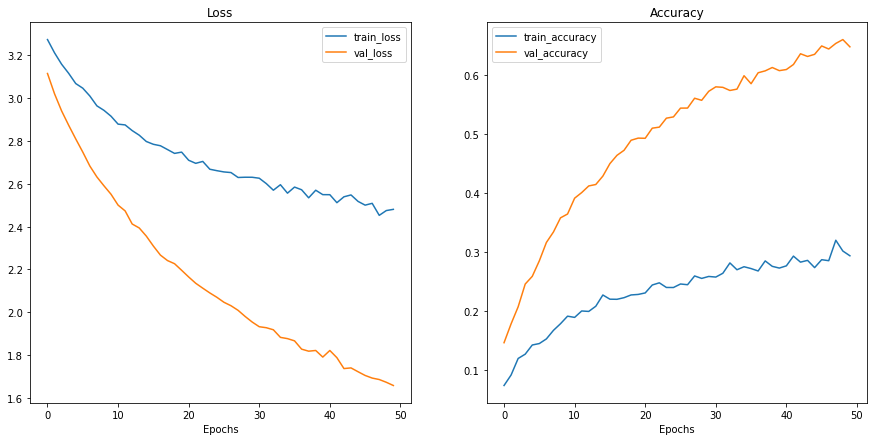

In [ ]:
loss_hist = {"train": results["train_loss"], "val": results["test_loss"]}
acc_hist = {"train": results["train_acc"], "val": results["test_acc"]}
                              
plot_loss_curves(loss_hist, acc_hist)

In [ ]:
torch.cuda.empty_cache() 

# Bird Class Training

In [ ]:
train_bird_dl, test_bird_dl, bird_classes = data_setup.create_dataloaders(
                                                            train_dir=train_bird,
                                                            test_dir=test_bird,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_bird_dl, test_bird_dl, bird_classes

(<torch.utils.data.dataloader.DataLoader at 0x7f6a2026d520>,
 ['Americancoot',
  'Europeangallinule',
  'albatross',
  'baldeagle',
  'blackgrouse',
  'brambling',
  'bulbul',
  'bustard',
  'chickadee',
  'cock',
  'dowitcher',
  'goldfinch',
  'greatgreyowl',
  'hen',
  'housefinch',
  'indigobunting',
  'jay',
  'junco',
  'kingpenguin',
  'magpie',
  'ostrich',
  'oystercatcher',
  'pelican',
  'ptarmigan',
  'red-backedsandpiper',
  'redshank',
  'robin',
  'ruddyturnstone',
  'vulture',
  'waterouzel'])

In [ ]:
weights = weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
bird_model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

# Freeze all base layers in the "features" section of the model
#layers = [bird_model.conv_proj.parameters(), bird_model.encoder.parameters()]
for param in bird_model.parameters():
  param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(bird_classes)

# Recreate the classifier layer and seed it to the target device
bird_model.classifier[1] = nn.Linear(1280, output_shape)
#dog_model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
 #   torch.nn.Linear(in_features=1024, 
  #                  out_features=output_shape, # same number of output units as our number of classes
   #                 bias=True)).to(device)

#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.parameters(), lr=0.001)

In [ ]:
try:
  bird_model.load_state_dict(torch.load('/content/drive/MyDrive/NNDL/Released_Data/models/efficientnet_bird.pth'))
except:
  pass

In [ ]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=bird_model,
                train_dataloader=train_bird_dl,
                test_dataloader=test_bird_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=50,
                device=device,
                save_path='/content/drive/MyDrive/NNDL/Released_Data/models/efficientnet_bird.pth',
                early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9280 | train_acc: 0.1931 | test_loss: 2.5937 | test_acc: 0.3586
Epoch: 2 | train_loss: 2.9150 | train_acc: 0.1926 | test_loss: 2.5709 | test_acc: 0.3822
Epoch: 3 | train_loss: 2.8834 | train_acc: 0.2131 | test_loss: 2.5094 | test_acc: 0.4119
Epoch: 4 | train_loss: 2.8682 | train_acc: 0.2116 | test_loss: 2.4950 | test_acc: 0.3965
Epoch: 5 | train_loss: 2.8839 | train_acc: 0.1911 | test_loss: 2.4493 | test_acc: 0.4124
Epoch: 6 | train_loss: 2.8191 | train_acc: 0.2167 | test_loss: 2.4284 | test_acc: 0.4262
Epoch: 7 | train_loss: 2.8208 | train_acc: 0.2177 | test_loss: 2.3659 | test_acc: 0.4273
Epoch: 8 | train_loss: 2.7906 | train_acc: 0.2305 | test_loss: 2.3882 | test_acc: 0.4221
Epoch: 9 | train_loss: 2.7893 | train_acc: 0.2300 | test_loss: 2.3186 | test_acc: 0.4534
Epoch: 10 | train_loss: 2.7334 | train_acc: 0.2433 | test_loss: 2.2983 | test_acc: 0.4508
Epoch: 11 | train_loss: 2.7467 | train_acc: 0.2474 | test_loss: 2.2618 | test_acc: 0.4841
Epoch: 12 | train_l

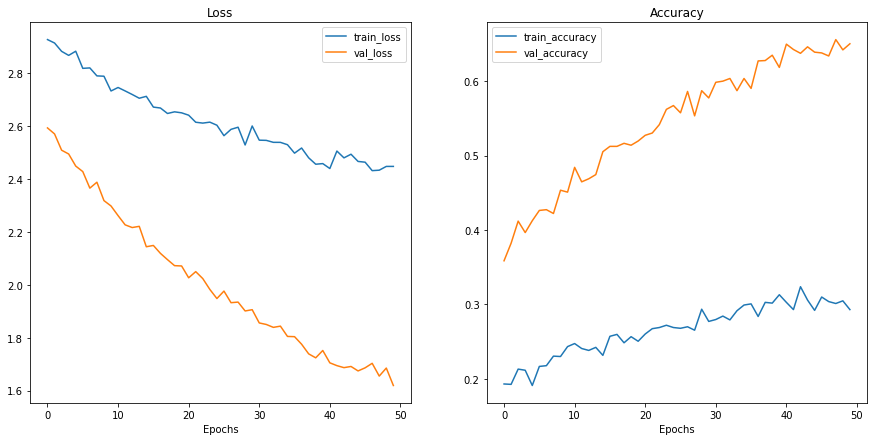

In [ ]:
loss_hist = {"train": results["train_loss"], "val": results["test_loss"]}
acc_hist = {"train": results["train_acc"], "val": results["test_acc"]}
                              
plot_loss_curves(loss_hist, acc_hist)

In [ ]:
torch.cuda.empty_cache() 

# Reptile Class Training

In [ ]:
print(train_rep)

/content/drive/MyDrive/NNDL/Released_Data/train/ and DL/projects/Released_Data/train/reptile


In [ ]:
train_rep_dl, test_rep_dl, rep_classes = data_setup.create_dataloaders(
                                                            train_dir=train_rep,
                                                            test_dir=test_rep,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_rep_dl, test_rep_dl, rep_classes

(<torch.utils.data.dataloader.DataLoader at 0x7f6a201d0100>,
 ['Africanchameleon',
  'Africancrocodile',
  'Americanalligator',
  'Americanchameleon',
  'Europeanfiresalamander',
  'Gilamonster',
  'Komododragon',
  'agama',
  'alligatorlizard',
  'axolotl',
  'bandedgecko',
  'bullfrog',
  'commoniguana',
  'commonnewt',
  'eft',
  'frilledlizard',
  'greenlizard',
  'greensnake',
  'hognosesnake',
  'leatherbackturtle',
  'loggerhead',
  'mudturtle',
  'ringnecksnake',
  'spottedsalamander',
  'tailedfrog',
  'terrapin',
  'thundersnake',
  'treefrog',
  'triceratops',
  'whiptail'])

In [ ]:
weights = weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
rep_model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

# Freeze all base layers in the "features" section of the model
#layers = [rep_model.conv_proj.parameters(), rep_model.encoder.parameters()]
for param in rep_model.parameters():
  param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(rep_classes)

# Recreate the classifier layer and seed it to the target device
rep_model.classifier[1] = nn.Linear(1280, output_shape)
#dog_model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
 #   torch.nn.Linear(in_features=1024, 
  #                  out_features=output_shape, # same number of output units as our number of classes
   #                 bias=True)).to(device)
try:
  rep_model.load_state_dict(torch.load('/content/drive/MyDrive/NNDL/Released_Data/models/efficientnet_rep.pth'))
except:
  pass
#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rep_model.parameters(), lr=0.001)

In [ ]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_rep = train(model=rep_model,
                    train_dataloader=train_rep_dl,
                    test_dataloader=test_rep_dl,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=25,
                    device=device,
                    save_path='/content/drive/MyDrive/NNDL/Released_Data/models/efficientnet_rep.pth',
                    early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4253 | train_acc: 0.0384 | test_loss: 3.2612 | test_acc: 0.0990
Epoch: 2 | train_loss: 3.3243 | train_acc: 0.0601 | test_loss: 3.1647 | test_acc: 0.1335
Epoch: 3 | train_loss: 3.2689 | train_acc: 0.0835 | test_loss: 3.0741 | test_acc: 0.1688
Epoch: 4 | train_loss: 3.2121 | train_acc: 0.1030 | test_loss: 2.9948 | test_acc: 0.2093
Epoch: 5 | train_loss: 3.1723 | train_acc: 0.1144 | test_loss: 2.9290 | test_acc: 0.2399
Epoch: 6 | train_loss: 3.1381 | train_acc: 0.1286 | test_loss: 2.8612 | test_acc: 0.2546
Epoch: 7 | train_loss: 3.0863 | train_acc: 0.1347 | test_loss: 2.8140 | test_acc: 0.2706
Epoch: 8 | train_loss: 3.0583 | train_acc: 0.1457 | test_loss: 2.7649 | test_acc: 0.2834
Epoch: 9 | train_loss: 3.0136 | train_acc: 0.1520 | test_loss: 2.6917 | test_acc: 0.3140
Epoch: 10 | train_loss: 3.0155 | train_acc: 0.1642 | test_loss: 2.6708 | test_acc: 0.3134
Epoch: 11 | train_loss: 2.9688 | train_acc: 0.1756 | test_loss: 2.6179 | test_acc: 0.3461
Epoch: 12 | train_l

In [ ]:
loss_hist = {"train": results_rep["train_loss"], "val": results_rep["test_loss"]}
acc_hist = {"train": results_rep["train_acc"], "val": results_rep["test_acc"]}
                              
plot_loss_curves(loss_hist, acc_hist)

In [ ]:
torch.cuda.empty_cache()

# Test Importing Weights

In [ ]:
eff_net_import = torch.load('/content/drive/MyDrive/NNDL/Released_Data/models/efficientnet_v2_s.pth', map_location=torch.device(device))

In [ ]:
en_model = torchvision.models.efficientnet_v2_s()
en_model.classifier[1] = nn.Linear(1280, 3)
en_model.load_state_dict(eff_net_import)
en_model.to(device)

In [ ]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          #print(outputs.data)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on test images: {100 * correct // total} %')

In [ ]:
test_model(en_model, test_dataloader)

Accuracy of the network on test images: 36 %
